# 1. Setup


## 1.1 Install Dependencies


In [2]:
# Install Tensorflow version 2.4.1
# Install the required drivers and packages: https://www.tensorflow.org/install
# Here is a helpful guide that I used to set up the TF environment: https://towardsdatascience.com/install-tensorflow-with-cuda-cudnn-and-gpu-support-in-4-easy-steps-954f176daac3

# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib --user
!pip install tensorflow - -user opencv-python matplotlib numpy pandas seaborn protobuf == 3.20.* scikit-learn



Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


## 1.2 Check the Available Devices

##### (Optional. Helps troubleshoot if the GPU is being used)


In [3]:
# Check if the GPU is detected. If not, the model will take a very long time to train.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3110676867861078079
xla_global_id: -1
]


## 1.3 Import Data Visualization Libraries and Image Processing Libraries


In [4]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

## 1.4 Import TensorFlow and Keras libraries


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 2. Load and Preprocess the Data


## 2.1. Loading and Preprocessing Training Data


In [6]:
# "./input/standard-ocr-dataset/data/training_data"
# import os
# import numpy as np
# from PIL import Image

train_dir = './input/standard-ocr-dataset/data/training_data'
classes = os.listdir(train_dir)

X_train = []
y_train = []

for i, c in enumerate(classes):
    class_dir = os.path.join(train_dir, c)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        img = np.array(img)
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


C:\Users\Sagar\AppData\Local\Temp\ipykernel_7344\525592075.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)


## 2.2. Data Loading and Distribution Visualization


Found 20628 images belonging to 36 classes.
Found 1008 images belonging to 36 classes.


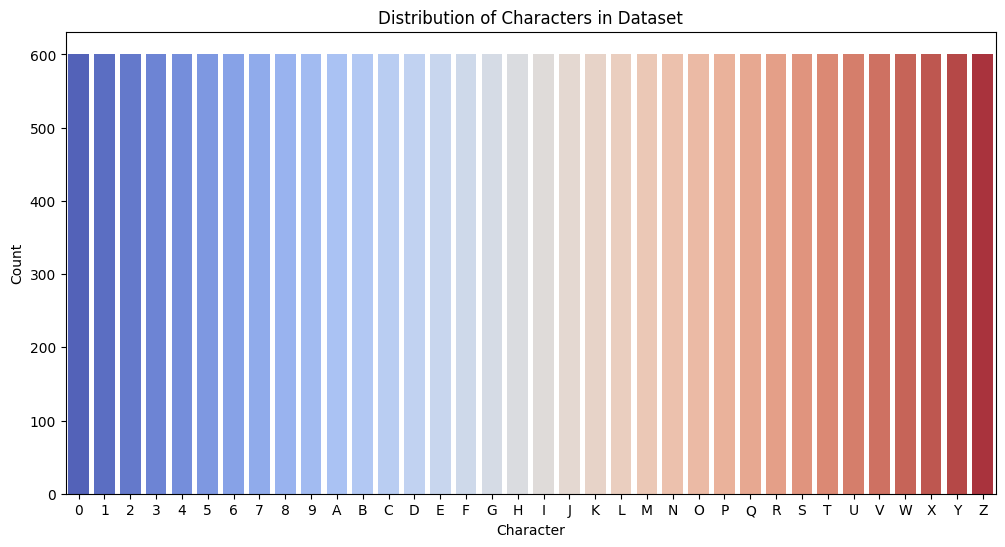

In [7]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up directories
train_dir = './input/standard-ocr-dataset/data/training_data'
test_dir = './input/standard-ocr-dataset/data/testing_data'

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(32, 32),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical')

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical')

# Concatenate training and testing data
all_data = np.concatenate([train_data.labels, test_data.labels])

# Create character list
characters = [chr(i) for i in range(48, 58)] + [chr(i) for i in range(65, 91)]

# Create countplot of character distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=all_data, palette='coolwarm')
plt.xlabel('Character')
plt.ylabel('Count')
plt.xticks(np.arange(36), characters)
plt.title('Distribution of Characters in Dataset')
plt.show()


## 2.3. Preview of the Dataset with Random Images


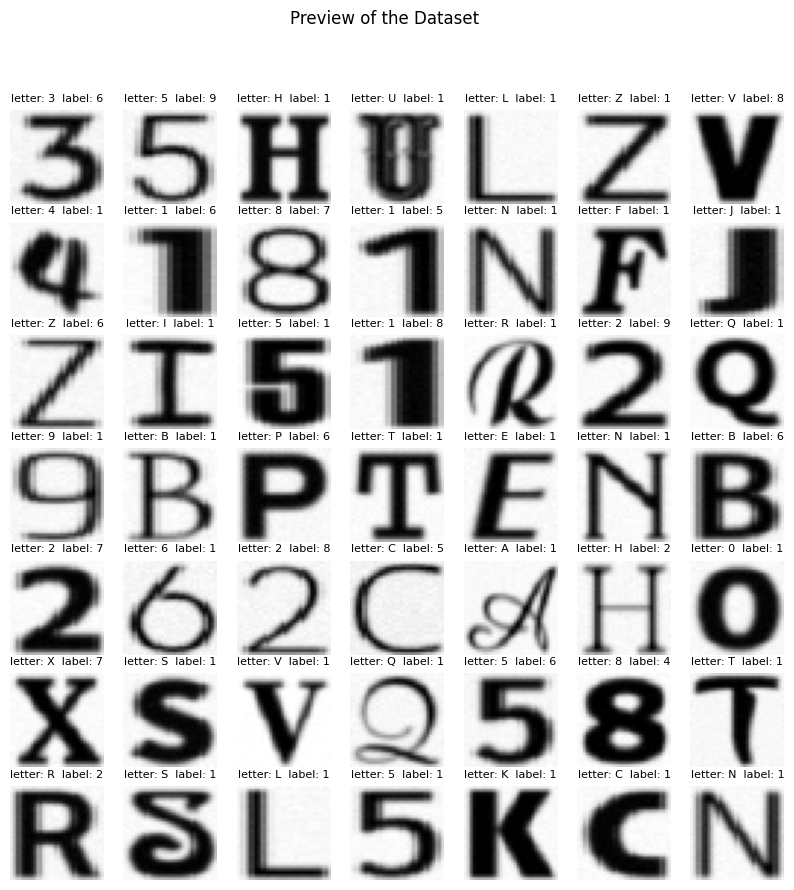

In [8]:
# import os
# import random
# import matplotlib.pyplot as plt
# from PIL import Image

fig, axe = plt.subplots(7, 7, figsize=(10, 10))
fig.suptitle('Preview of the Dataset')

for i in range(7):
    for j in range(7):
        idx = i*7+j
        label_dir = os.path.join('./input/standard-ocr-dataset/data/training_data', str(
            random.choice(list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"))))
        img_path = os.path.join(
            label_dir, random.choice(os.listdir(label_dir)))
        img = Image.open(img_path)
        img = img.resize((32, 32), resample=Image.BOX)
        axe[i, j].imshow(img, cmap='gray')
        axe[i, j].set_title('letter: {}  label: {}'.format(
            os.path.basename(label_dir), os.path.basename(img_path)[0]), fontsize=8)
        axe[i, j].axis('off')

plt.show()


## 2.4. Defining ImageDataGenerator Objects for Data Augmentation and Normalization


In [9]:
# Define an ImageDataGenerator object for data augmentation with the following settings:
augmented_image_gen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to range [0, 1]
    rotation_range=15,  # randomly rotate images up to 15 degrees
    width_shift_range=0.1,  # randomly shift the width of the image by up to 10%
    height_shift_range=0.1,  # randomly shift the height of the image by up to 10%
    shear_range=0.1,  # randomly apply shear transformation up to 10%
    zoom_range=0.1,  # randomly zoom into the image up to 10%
    horizontal_flip=False,  # do not horizontally flip the image
    fill_mode='nearest',  # use nearest pixel to fill gaps after transformations
    # randomly adjust brightness between 50% and 150%
    brightness_range=[0.5, 1.5],
    validation_split=0.2  # split the data into training and validation sets with 80/20 ratio
)

# Define an ImageDataGenerator object for normalizing the pixel values of test images
normal_image_gen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to range [0, 1]
    validation_split=0.2  # split the data into training and validation sets with 80/20 ratio
)


## 2.5. Setting up image data generators for training and validation sets


In [10]:
# Define constants and variables
batch_size = 32
epochs = 32
image_height = 32
image_width = 32
seed = 12345
data_dir = "./input/standard-ocr-dataset/data/"

# Create image data generators
train_data_gen = augmented_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=data_dir + "training_data",
    color_mode="grayscale",
    shuffle=True,
    target_size=(image_height, image_width),
    class_mode="categorical",
    seed=seed,
    subset='training'
)

val_data_gen = normal_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=data_dir + "testing_data",
    color_mode="grayscale",
    shuffle=True,
    target_size=(image_height, image_width),
    class_mode="categorical",
    seed=seed,
    subset='validation'
)


Found 16524 images belonging to 36 classes.
Found 180 images belonging to 36 classes.


# 3. Creating the Deep Learning Model


## 3.1. Defining and compiling a Convolutional Neural Network (CNN) for image classification using Keras.


In [11]:
# Import SGD optimizer from Keras library
# from tensorflow.keras.optimizers import SGD

# Define the architecture of a Convolutional Neural Network (CNN)


def define_model():
    # Instantiate a sequential model
    model = Sequential()

    # Add a 2D convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and He uniform weight initialization
    model.add(Conv2D(32, (3, 3), activation='relu',
              kernel_initializer='he_uniform', input_shape=(32, 32, 1)))

    # Add a max pooling layer with a 2x2 pool size
    model.add(MaxPooling2D((2, 2)))

    # Add a flatten layer to convert the 2D feature maps to 1D feature vectors
    model.add(Flatten())

    # Add a fully connected layer with 100 neurons, ReLU activation, and He uniform weight initialization
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

    # Add a final fully connected layer with 36 neurons (one for each class), softmax activation, and default weight initialization
    model.add(Dense(36, activation='softmax'))

    # Return the model
    return model


# Instantiate the model
model = define_model()

# Define optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Compile the model with categorical cross-entropy loss and accuracy metric
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])


## 3.2. Testing an OCR model on a standard dataset and generating classification report and confusion matrix.


32/32 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        28
           5       0.00      0.00      0.00        28
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00        28
           9       0.00      0.00      0.00        28
           A       0.00      0.00      0.00        28
           B       0.00      0.00      0.00        28
           C       0.01      0.04      0.01        28
           D       0.03      0.50      0.05        28
           E       0.00      0.00      0.00        28
           F       0.00      0.00      0.00        28
           G       0.00     

C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sagar\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


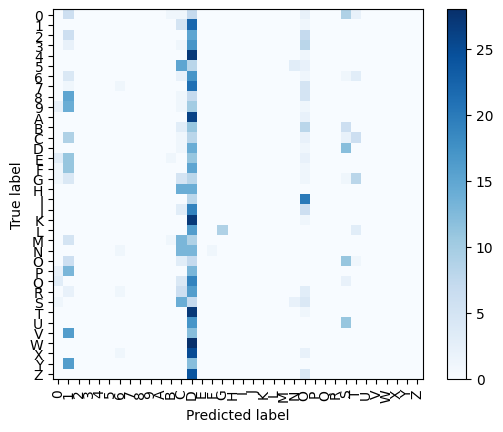

In [12]:
# import os
# import numpy as np
# import cv2
# from sklearn.metrics import classification_report, confusion_matrix

test_dir = './input/standard-ocr-dataset/data/testing_data'
classes = os.listdir(test_dir)
num_classes = len(classes)

# Load images and labels for each subfolder
X_test = []
y_test = []
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(test_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Resize image to match input size of your model
        img = cv2.resize(img, (32, 32))
        X_test.append(img)
        y_test.append(class_idx)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Make predictions
y_pred = model.predict(X_test)

# Get predicted class labels
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(num_classes), classes, rotation=90)
plt.yticks(np.arange(num_classes), classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## 3.3. Defining Callbacks and Training the Model


In [13]:
# import tensorflow
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Prepare callbacks
EarlyStop_callback = EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('./checkpoint',
                             monitor='val_loss', mode='min', save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                       patience=3, min_lr=0.00001)
my_callback = [EarlyStop_callback, checkpoint]

# Training our model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])

# set logging level to INFO to avoid warning messages
tf.get_logger().setLevel('INFO')
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=32,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=my_callback)


Epoch 1/32
516/516 [==============================] - ETA: 0s - loss: 2.1929 - categorical_accuracy: 0.3663

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 21s 39ms/step - loss: 2.1929 - categorical_accuracy: 0.3663 - val_loss: 0.3432 - val_categorical_accuracy: 0.9000
Epoch 2/32
516/516 [==============================] - ETA: 0s - loss: 0.9902 - categorical_accuracy: 0.7150

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 22s 43ms/step - loss: 0.9902 - categorical_accuracy: 0.7150 - val_loss: 0.1752 - val_categorical_accuracy: 0.9250
Epoch 3/32
516/516 [==============================] - 23s 44ms/step - loss: 0.6591 - categorical_accuracy: 0.8143 - val_loss: 0.2087 - val_categorical_accuracy: 0.9000
Epoch 4/32
516/516 [==============================] - ETA: 0s - loss: 0.5308 - categorical_accuracy: 0.8454

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 19s 38ms/step - loss: 0.5308 - categorical_accuracy: 0.8454 - val_loss: 0.1475 - val_categorical_accuracy: 0.9375
Epoch 5/32
515/516 [============================>.] - ETA: 0s - loss: 0.4799 - categorical_accuracy: 0.8641

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 23s 44ms/step - loss: 0.4795 - categorical_accuracy: 0.8641 - val_loss: 0.0840 - val_categorical_accuracy: 0.9563
Epoch 6/32
515/516 [============================>.] - ETA: 0s - loss: 0.4286 - categorical_accuracy: 0.8806

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 23s 44ms/step - loss: 0.4291 - categorical_accuracy: 0.8805 - val_loss: 0.0828 - val_categorical_accuracy: 0.9688
Epoch 7/32
516/516 [==============================] - ETA: 0s - loss: 0.3961 - categorical_accuracy: 0.8910

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 23s 44ms/step - loss: 0.3961 - categorical_accuracy: 0.8910 - val_loss: 0.0761 - val_categorical_accuracy: 0.9688
Epoch 8/32
516/516 [==============================] - 21s 41ms/step - loss: 0.3625 - categorical_accuracy: 0.8963 - val_loss: 0.1236 - val_categorical_accuracy: 0.9625
Epoch 9/32
515/516 [============================>.] - ETA: 0s - loss: 0.3593 - categorical_accuracy: 0.8987

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 20s 38ms/step - loss: 0.3596 - categorical_accuracy: 0.8988 - val_loss: 0.0716 - val_categorical_accuracy: 0.9625
Epoch 10/32
516/516 [==============================] - ETA: 0s - loss: 0.3317 - categorical_accuracy: 0.9049

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 22s 43ms/step - loss: 0.3317 - categorical_accuracy: 0.9049 - val_loss: 0.0550 - val_categorical_accuracy: 0.9750
Epoch 11/32
516/516 [==============================] - 21s 41ms/step - loss: 0.3241 - categorical_accuracy: 0.9101 - val_loss: 0.1017 - val_categorical_accuracy: 0.9500
Epoch 12/32
516/516 [==============================] - 19s 37ms/step - loss: 0.3132 - categorical_accuracy: 0.9087 - val_loss: 0.0717 - val_categorical_accuracy: 0.9563
Epoch 13/32
516/516 [==============================] - 19s 37ms/step - loss: 0.2985 - categorical_accuracy: 0.9127 - val_loss: 0.0556 - val_categorical_accuracy: 0.9625
Epoch 14/32
516/516 [==============================] - 19s 37ms/step - loss: 0.2895 - categorical_accuracy: 0.9137 - val_loss: 0.0717 - val_categorical_accuracy: 0.9688
Epoch 15/32
516/516 [==============================] - 19s 37ms/step - loss: 0.2876 - categorical_accuracy: 0.9171 - val_loss: 0.0649 - val_categorical_accuracy: 0.975

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 20s 38ms/step - loss: 0.2598 - categorical_accuracy: 0.9259 - val_loss: 0.0487 - val_categorical_accuracy: 0.9750
Epoch 21/32
515/516 [============================>.] - ETA: 0s - loss: 0.2372 - categorical_accuracy: 0.9301

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 22s 43ms/step - loss: 0.2373 - categorical_accuracy: 0.9300 - val_loss: 0.0343 - val_categorical_accuracy: 0.9812
Epoch 22/32
516/516 [==============================] - 22s 42ms/step - loss: 0.2345 - categorical_accuracy: 0.9291 - val_loss: 0.0437 - val_categorical_accuracy: 0.9750
Epoch 23/32
516/516 [==============================] - 19s 36ms/step - loss: 0.2258 - categorical_accuracy: 0.9323 - val_loss: 0.0608 - val_categorical_accuracy: 0.9688
Epoch 24/32
516/516 [==============================] - 19s 37ms/step - loss: 0.2274 - categorical_accuracy: 0.9332 - val_loss: 0.0667 - val_categorical_accuracy: 0.9750
Epoch 25/32
516/516 [==============================] - 19s 36ms/step - loss: 0.2166 - categorical_accuracy: 0.9336 - val_loss: 0.0572 - val_categorical_accuracy: 0.9688
Epoch 26/32
516/516 [==============================] - 21s 41ms/step - loss: 0.2232 - categorical_accuracy: 0.9312 - val_loss: 0.0354 - val_categorical_accuracy: 0.981

# 4. Testing and Evaluating the Model


## 4.1. Testing the Trained Model on New Data and Generating Classification Metrics


32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.57      0.93      0.70        28
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        28
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        28
           9       1.00      1.00      1.00        28
           A       1.00      1.00      1.00        28
           B       0.97      1.00      0.98        28
           C       0.90      0.96      0.93        28
           D       1.00      1.00      1.00        28
           E       0.96      0.96      0.96        28
           F       1.00      0.96      0.98        28
           G       1.00     

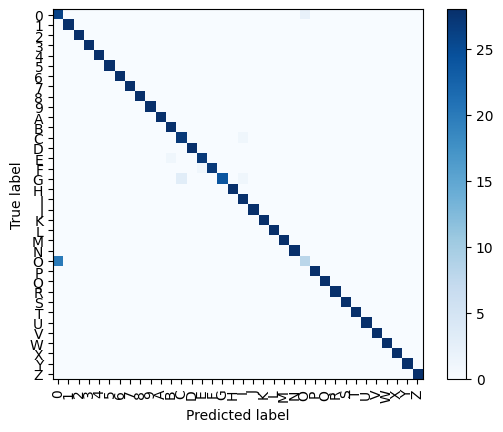

In [14]:
# import os
# import numpy as np
# import cv2
# from sklearn.metrics import classification_report, confusion_matrix

test_dir = './input/standard-ocr-dataset/data/testing_data'
classes = os.listdir(test_dir)
num_classes = len(classes)

# Load images and labels for each subfolder
X_test = []
y_test = []
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(test_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (32, 32)) # Resize image to match input size of your model
        X_test.append(img)
        y_test.append(class_idx)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Make predictions
y_pred = model.predict(X_test)

# Get predicted class labels
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(num_classes), classes, rotation=90)
plt.yticks(np.arange(num_classes), classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## 4.2. Plotting Training and Validation Accuracy/Loss over Epochs


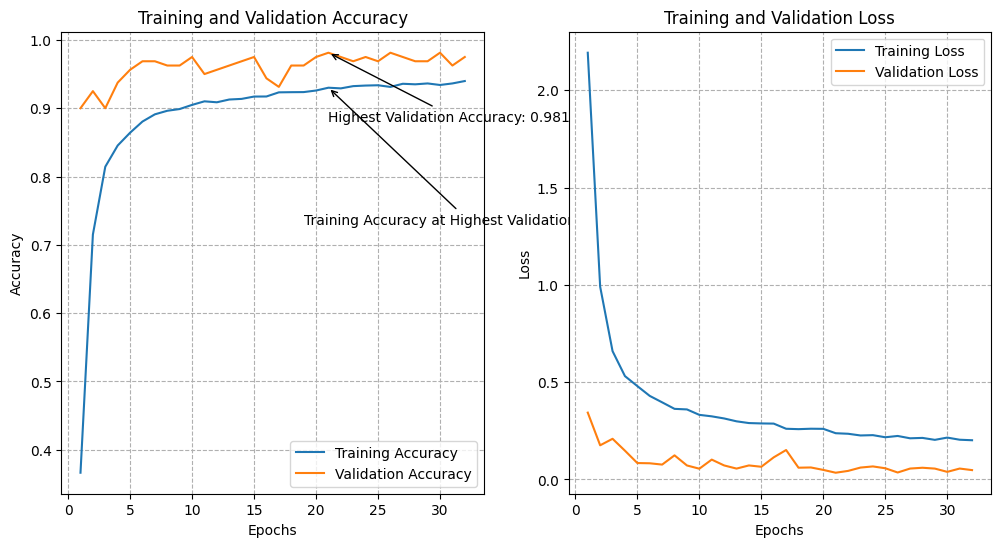

In [15]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, 33, 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(linestyle='--')

highest_val_acc = max(val_acc)
highest_val_acc_idx = val_acc.index(highest_val_acc) + 1
highest_train_acc = acc[highest_val_acc_idx-1]

plt.annotate(f'Highest Validation Accuracy: {highest_val_acc:.4f}', xy=(highest_val_acc_idx, highest_val_acc),
             xytext=(highest_val_acc_idx, highest_val_acc-0.1), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(f'Training Accuracy at Highest Validation: {highest_train_acc:.4f}', xy=(highest_val_acc_idx, highest_train_acc),
             xytext=(highest_val_acc_idx-2, highest_train_acc-0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(linestyle='--')

plt.show()


## 4.3. Generating Test Data for Image Classification using ImageDataGenerator


In [16]:
# Import required libraries
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image height and width
image_height = 32
image_width = 32

# Create ImageDataGenerator object for normalizing test images
normal_image_gen = ImageDataGenerator(
    samplewise_center=True,        # set each sample mean to 0
    samplewise_std_normalization=True  # divide each input by its std
)

# Generate test data from directory using ImageDataGenerator
test_data_gen = normal_image_gen.flow_from_directory(
    # path to testing images directory
    directory="./input/standard-ocr-dataset/data/testing_data",
    target_size=(image_height, image_width),     # resize images to this size
    color_mode="grayscale",         # convert images to grayscale
    class_mode="categorical",       # return 2D one-hot encoded labels
    shuffle=True,                   # shuffle order of the images
    batch_size=1008                 # number of images to be yielded per batch
)


Found 1008 images belonging to 36 classes.


## 4.4. Extracting predictions and labels for test data using a trained TensorFlow model.


In [17]:
# Import required libraries
# import tensorflow as tf
# from PIL import Image

# Generate test data and labels
test_images, test_labels = next(test_data_gen)

# Get filenames for test data
filenames = test_data_gen.filenames

# Make predictions on test data
test_pred = model.predict(test_images)

# Import necessary libraries

# Get true labels by finding the index of the maximum value in each row of test_labels
true_labels = tf.argmax(test_labels, 1)

# Get predicted labels by finding the index of the maximum value in each row of test_pred
predicted_labels = tf.argmax(test_pred, 1)


32/32 [==============================] - 0s 5ms/step


## 4.5. Testing the model's performance on sample images.


In [18]:
# Demonstrate that the model works

mapping = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
    19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
    28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'
}

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/H/28399.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/E/29008.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/L/28727.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/L/29159.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/O/28406.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)


1/1 [==============================] - 0s 73ms/step
H
1/1 [==============================] - 0s 22ms/step
E
1/1 [==============================] - 0s 26ms/step
L
1/1 [==============================] - 0s 23ms/step
L
1/1 [==============================] - 0s 22ms/step
O


In [19]:
# Define the path to the "word1" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word1"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word1", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


1/1 [==============================] - 0s 25ms/step
1.png H
1/1 [==============================] - 0s 23ms/step
2.png R
1/1 [==============================] - 0s 23ms/step
3.png L
1/1 [==============================] - 0s 26ms/step
4.png L
1/1 [==============================] - 0s 23ms/step
5.png Q


In [20]:
# Define the path to the "word2" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word2"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word2", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


1/1 [==============================] - 0s 26ms/step
1.png A
1/1 [==============================] - 0s 24ms/step
2.png E
1/1 [==============================] - 0s 24ms/step
3.png C
1/1 [==============================] - 0s 24ms/step
4.png A
1/1 [==============================] - 0s 31ms/step
5.png R


In [21]:
# Define the path to the "word3" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word3"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word3", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


1/1 [==============================] - 0s 22ms/step
1.png 0
1/1 [==============================] - 0s 23ms/step
2.png 0
1/1 [==============================] - 0s 22ms/step
3.png M
1/1 [==============================] - 0s 26ms/step
4.png U
1/1 [==============================] - 0s 23ms/step
5.png O
1/1 [==============================] - 0s 24ms/step
6.png 0


# 5. Retraining the Model at 5 Epochs


## 5.1. Defining and compiling a Convolutional Neural Network (CNN) model for classification using Keras library.


In [22]:
# Import SGD optimizer from Keras library
# from tensorflow.keras.optimizers import SGD

# Define the architecture of a Convolutional Neural Network (CNN)


def define_model():
    # Instantiate a sequential model
    model = Sequential()

    # Add a 2D convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and He uniform weight initialization
    model.add(Conv2D(5, (3, 3), activation='relu',
              kernel_initializer='he_uniform', input_shape=(32, 32, 1)))

    # Add a max pooling layer with a 2x2 pool size
    model.add(MaxPooling2D((2, 2)))

    # Add a flatten layer to convert the 2D feature maps to 1D feature vectors
    model.add(Flatten())

    # Add a fully connected layer with 100 neurons, ReLU activation, and He uniform weight initialization
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))

    # Add a final fully connected layer with 36 neurons (one for each class), softmax activation, and default weight initialization
    model.add(Dense(36, activation='softmax'))

    # Return the model
    return model


# Instantiate the model
model = define_model()

# Define optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Compile the model with categorical cross-entropy loss and accuracy metric
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])


## 5.2. Modifying and Training the Model with Callbacks.


In [23]:
# Changing number of epochs to 5
# import tensorflow
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Prepare callbacks
EarlyStop_callback = EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('./checkpoint',
                             monitor='val_loss', mode='min', save_best_only=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                       patience=3, min_lr=0.00001)
my_callback = [EarlyStop_callback, checkpoint]

# Training our model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['categorical_accuracy'])

# set logging level to INFO to avoid warning messages
tf.get_logger().setLevel('INFO')
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=5,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=my_callback)


Epoch 1/5
515/516 [============================>.] - ETA: 0s - loss: 2.0082 - categorical_accuracy: 0.4358

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 20s 38ms/step - loss: 2.0061 - categorical_accuracy: 0.4363 - val_loss: 0.3000 - val_categorical_accuracy: 0.8938
Epoch 2/5
515/516 [============================>.] - ETA: 0s - loss: 1.1537 - categorical_accuracy: 0.6735

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 22s 42ms/step - loss: 1.1537 - categorical_accuracy: 0.6736 - val_loss: 0.1785 - val_categorical_accuracy: 0.9500
Epoch 3/5
515/516 [============================>.] - ETA: 0s - loss: 0.9361 - categorical_accuracy: 0.7323

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 22s 42ms/step - loss: 0.9358 - categorical_accuracy: 0.7324 - val_loss: 0.1279 - val_categorical_accuracy: 0.9563
Epoch 4/5
515/516 [============================>.] - ETA: 0s - loss: 0.7931 - categorical_accuracy: 0.7817

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


516/516 [==============================] - 22s 42ms/step - loss: 0.7927 - categorical_accuracy: 0.7817 - val_loss: 0.1087 - val_categorical_accuracy: 0.9563
Epoch 5/5
516/516 [==============================] - 21s 41ms/step - loss: 0.7107 - categorical_accuracy: 0.8054 - val_loss: 0.1162 - val_categorical_accuracy: 0.9375


## 5.3. Testing and evaluating the performance of a trained image classification model on a standard OCR dataset.


32/32 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.45      0.75      0.56        28
           1       0.96      0.82      0.88        28
           2       1.00      1.00      1.00        28
           3       0.84      0.93      0.88        28
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        28
           6       1.00      0.93      0.96        28
           7       1.00      1.00      1.00        28
           8       0.78      1.00      0.88        28
           9       1.00      0.79      0.88        28
           A       1.00      1.00      1.00        28
           B       0.97      1.00      0.98        28
           C       1.00      0.57      0.73        28
           D       0.97      1.00      0.98        28
           E       1.00      1.00      1.00        28
           F       1.00      1.00      1.00        28
           G       0.68     

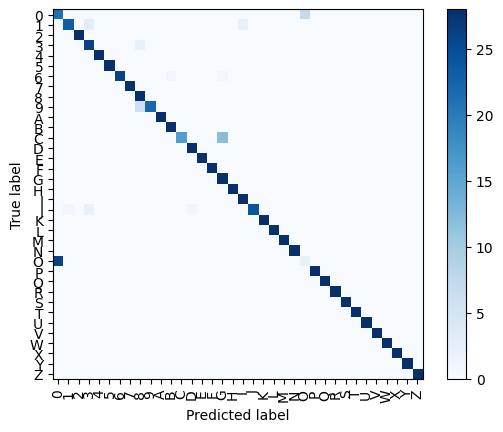

In [24]:
# import os
# import numpy as np
# import cv2
# from sklearn.metrics import classification_report, confusion_matrix

test_dir = './input/standard-ocr-dataset/data/testing_data'
classes = os.listdir(test_dir)
num_classes = len(classes)

# Load images and labels for each subfolder
X_test = []
y_test = []
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(test_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Resize image to match input size of your model
        img = cv2.resize(img, (32, 32))
        X_test.append(img)
        y_test.append(class_idx)

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Make predictions
y_pred = model.predict(X_test)

# Get predicted class labels
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(num_classes), classes, rotation=90)
plt.yticks(np.arange(num_classes), classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## 5.4. Plotting Training and Validation Accuracy/Loss over Epochs with Annotations


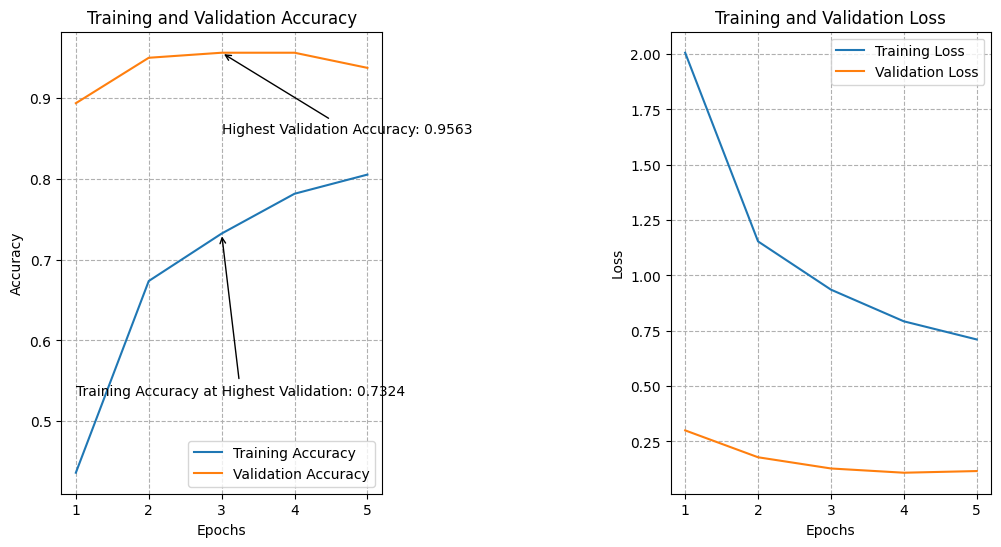

In [25]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, 6, 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(linestyle='--')

highest_val_acc = max(val_acc)
highest_val_acc_idx = val_acc.index(highest_val_acc) + 1
highest_train_acc = acc[highest_val_acc_idx-1]

plt.annotate(f'Highest Validation Accuracy: {highest_val_acc:.4f}', xy=(highest_val_acc_idx, highest_val_acc),
             xytext=(highest_val_acc_idx, highest_val_acc-0.1), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(f'Training Accuracy at Highest Validation: {highest_train_acc:.4f}', xy=(highest_val_acc_idx, highest_train_acc),
             xytext=(highest_val_acc_idx-2, highest_train_acc-0.2), arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(linestyle='--')

plt.subplots_adjust(wspace=0.9)
plt.show()


## 5.5. Testing the model's performance on sample images.


In [26]:
# Demonstrate that the model works

mapping = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I',
    19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
    28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'
}

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/H/28399.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/E/29008.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/L/28727.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/L/29159.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)

img = cv2.imread(
    './input/standard-ocr-dataset/data/testing_data/O/28406.png', 0)
img = cv2.resize(img, (32, 32))
img = img.reshape((1, 32, 32, 1))

output = tf.argmax(model.predict(img), 1)
predicted_char = mapping[output.numpy()[0]]
print(predicted_char)


1/1 [==============================] - 0s 79ms/step
H
1/1 [==============================] - 0s 20ms/step
E
1/1 [==============================] - 0s 24ms/step
L
1/1 [==============================] - 0s 22ms/step
L
1/1 [==============================] - 0s 22ms/step
0


In [27]:
# Define the path to the "word1" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word1"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word1", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


1/1 [==============================] - 0s 71ms/step
1.png R
1/1 [==============================] - 0s 22ms/step
2.png R
1/1 [==============================] - 0s 21ms/step
3.png L
1/1 [==============================] - 0s 25ms/step
4.png L
1/1 [==============================] - 0s 21ms/step
5.png Q


In [28]:
# Define the path to the "word2" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word2"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word2", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


1/1 [==============================] - 0s 25ms/step
1.png 4
1/1 [==============================] - 0s 22ms/step
2.png 8
1/1 [==============================] - 0s 21ms/step
3.png L
1/1 [==============================] - 0s 23ms/step
4.png 5
1/1 [==============================] - 0s 23ms/step
5.png R


In [29]:
# Define the path to the "word3" folder

# Loop over every image in the folder
for filename in os.listdir("./input/standard-ocr-dataset/word3"):
    # Load the image and preprocess it
    img = cv2.imread(os.path.join(
        "./input/standard-ocr-dataset/word3", filename), 0)
    img = img / 255
    img = cv2.resize(img, (32, 32))
    img = img.reshape((1, 32, 32, 1))

    # Predict the character and print it
    output = tf.argmax(model.predict(img), 1)
    predicted_char = mapping[output.numpy()[0]]
    print(filename, predicted_char)


1/1 [==============================] - 0s 26ms/step
1.png 0
1/1 [==============================] - 0s 24ms/step
2.png 4
1/1 [==============================] - 0s 23ms/step
3.png 4
1/1 [==============================] - 0s 23ms/step
4.png G
1/1 [==============================] - 0s 26ms/step
5.png O
1/1 [==============================] - 0s 23ms/step
6.png Q
